In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

In [24]:
df=pd.read_csv(r"G:\LILTHOMA\Learn\Internships\Mentoress\Machine Learning Internship MIP-ML-11\Market Price Prediction\MarketPricePrediction.csv")
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


In [25]:
df['date']=pd.to_datetime(df['date'])

In [26]:
#THIS CODE IMPUTES THE MISSING VALUES BY TAKING THE CLASSES DIFFERENTLY
#CODE FORMULATION DONE IN THE clean-data notebook
import warnings
warnings.filterwarnings("ignore")
markets=df['market'].unique()
cols=["market","date","quantity","priceMin","priceMax","priceMod"]
df_list=[]
for i in markets:
    filtered_df=df[df["market"]==i]
    filtered_df=filtered_df[cols]
    min_date=filtered_df['date'].min()
    max_date=filtered_df['date'].max()
    date_range=pd.date_range(start=min_date,end=max_date,freq="MS")
    filtered_df.set_index("date",drop=True,inplace=True)
    missing_date=date_range[~date_range.isin(filtered_df.index)]
    date_reindexed=filtered_df.reindex(date_range)
    data=date_reindexed.interpolate(method="linear")
    data['market']=data['market'].fillna(data['market'].mode())
    df_list.append(data)
cleaned_df=pd.concat(df_list,axis=0)
cleaned_df['market'].fillna(method="ffill",inplace=True)

In [27]:
cleaned_df

,market,quantity,priceMin,priceMax,priceMod
2005-01-01,ABOHAR(PB),2350.0,404.0,493.0,446.0
2005-02-01,ABOHAR(PB),1400.0,286.0,365.0,324.0
2005-03-01,ABOHAR(PB),900.0,281.0,357.0,322.0
2005-04-01,ABOHAR(PB),637.5,335.5,453.5,398.5
2005-05-01,ABOHAR(PB),375.0,390.0,550.0,475.0
...,...,...,...,...,...
2015-10-01,YEOLA(MS),15593.0,1046.0,3537.0,2886.0
2015-11-01,YEOLA(MS),62522.0,1003.0,2460.0,1996.0
2015-12-01,YEOLA(MS),223315.0,609.0,1446.0,1126.0
2016-01-01,YEOLA(MS),437432.0,437.0,1272.0,1034.0


### Building a ARIMA Model and Auto ARIMA model(Univariate Time Series Forecasting) 
* For a single class and single target variable or time dependant variable


In [28]:
stock_df=cleaned_df[cleaned_df['market']=='ABOHAR(PB)']['priceMod']

<Axes: >

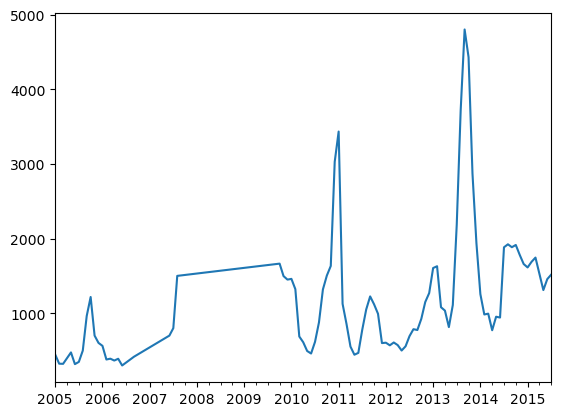

In [29]:
stock_df.plot()

### Time Decomposition


In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

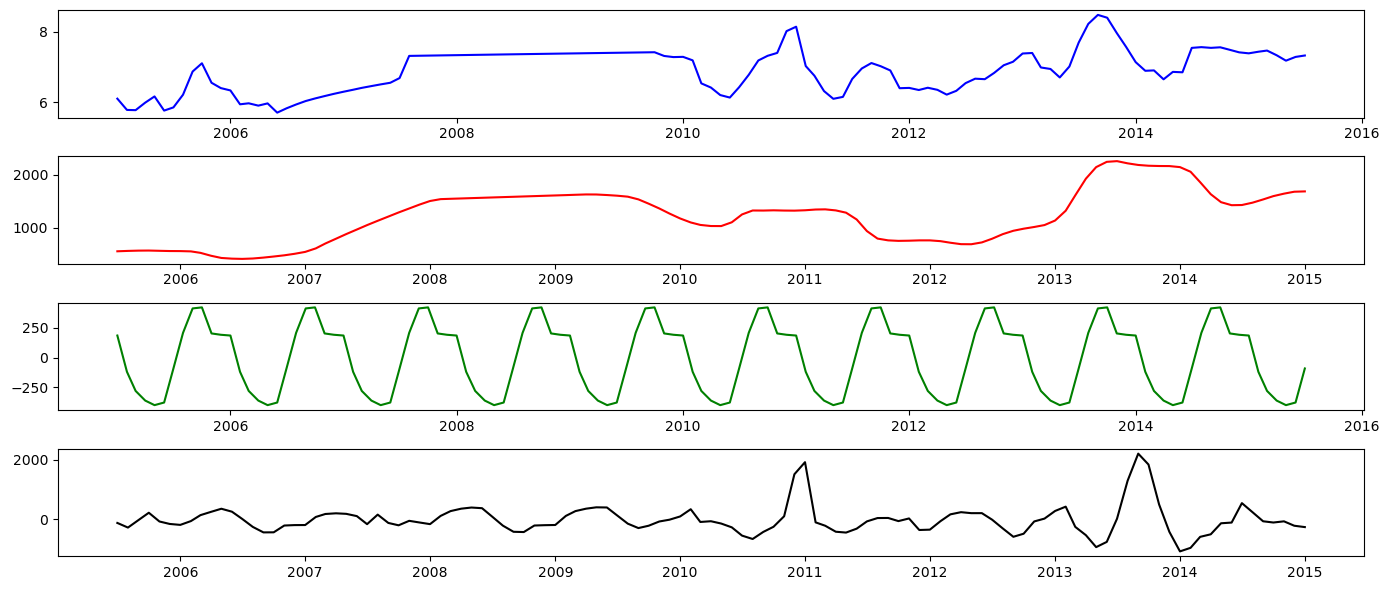

In [31]:
decomposition=seasonal_decompose(stock_df)
trend=decomposition.trend
seasonality=decomposition.seasonal
residual=decomposition.resid

plt.figure(figsize=(14,6))
plt.subplot(411)
plt.plot(np.log(stock_df),label="Orginal",color="blue")
plt.subplot(412)
plt.plot(trend,label="trend",color="red")
plt.subplot(413)
plt.plot(seasonality,label="seasonality",color="green")
plt.subplot(414)
plt.plot(residual,label="Residual",color="black")
plt.tight_layout()

In [32]:
# Testing for stationarity
#adfuller test
from statsmodels.tsa.stattools import adfuller

In [33]:
def dicky_fuller(series):
    test=adfuller(series)
    df_output=pd.Series(test[0:4],index=['Test Statistic','p_value','#Lags used',"Number of Observations used"])
    for key,value in test[4].items():
        df_output['Critical values (%s)'%key]=value
    if test[1] <=0.05:
        print("P value less than 0.05 enough evidence that this data is stationary and the data has no unit root")
    else:
        print("P val is greater than 0.05 and we conclude that the data is not stationary and the data has a unit root")
    print(df_output)


dicky_fuller(stock_df)  


P value less than 0.05 enough evidence that this data is stationary and the data has no unit root
Test Statistic                  -4.922341
p_value                          0.000032
#Lags used                       1.000000
Number of Observations used    125.000000
Critical values (1%)            -3.483779
Critical values (5%)            -2.884954
Critical values (10%)           -2.579257
dtype: float64


In [34]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

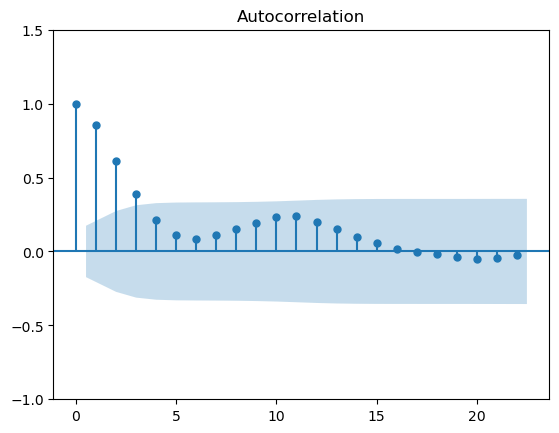

In [35]:
acf=plot_acf(stock_df)
plt.ylim(-1,1.5)
q=3

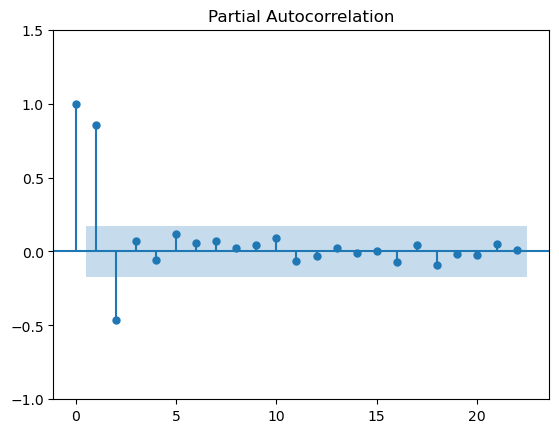

In [36]:
pacf=plot_pacf(stock_df)
plt.ylim(-1,1.5)
p=2

In [37]:
from statsmodels.tsa.arima.model import ARIMA

In [38]:
stock_df

2005-01-01     446.0
2005-02-01     324.0
2005-03-01     322.0
2005-04-01     398.5
2005-05-01     475.0
               ...  
2015-03-01    1745.0
2015-04-01    1527.5
2015-05-01    1310.0
2015-06-01    1457.0
2015-07-01    1517.0
Name: priceMod, Length: 127, dtype: float64

In [39]:
from datetime import datetime,timedelta
train_data_end=datetime(2012,5,1)
test_data_end=datetime(2016,2,1)

In [40]:
train_data=stock_df[:train_data_end]
test_data=stock_df[train_data_end+timedelta(days=1):test_data_end]

In [41]:
test_data=pd.DataFrame(test_data)

In [42]:
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [43]:
arima=ARIMA(train_data,order=(p,0,q))

In [44]:
model=arima.fit()

In [45]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:               priceMod   No. Observations:                   89
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -636.951
Date:                Thu, 23 May 2024   AIC                           1287.901
Time:                        13:19:50   BIC                           1305.322
Sample:                    01-01-2005   HQIC                          1294.923
                         - 05-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1024.6951    342.426      2.992      0.003     353.553    1695.837
ar.L1          1.5811      1.224      1.291      0.197      -0.819       3.981
ar.L2         -0.6074      1.061     -0.572      0.5

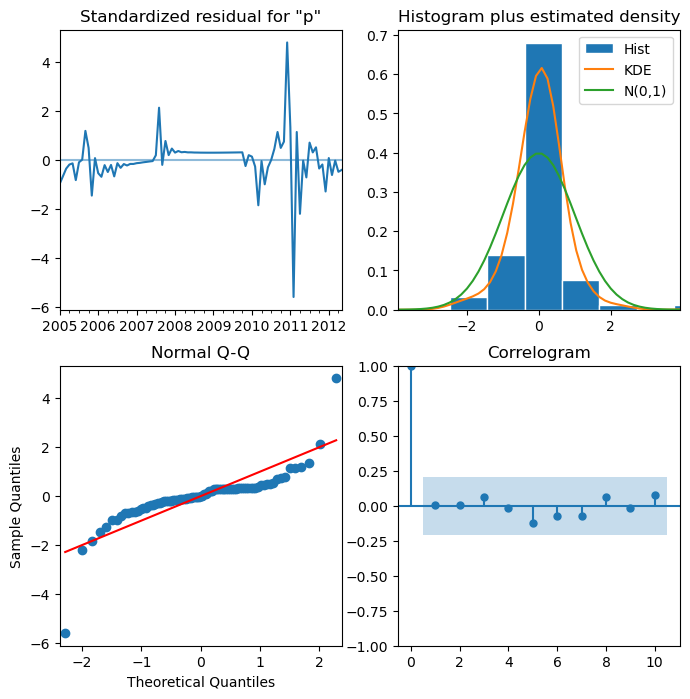

In [100]:
daigs=model.plot_diagnostics(figsize=(8,8))

In [46]:
pred=model.predict(start=pred_start_date,end=pred_end_date)

<Axes: ylabel='Density'>

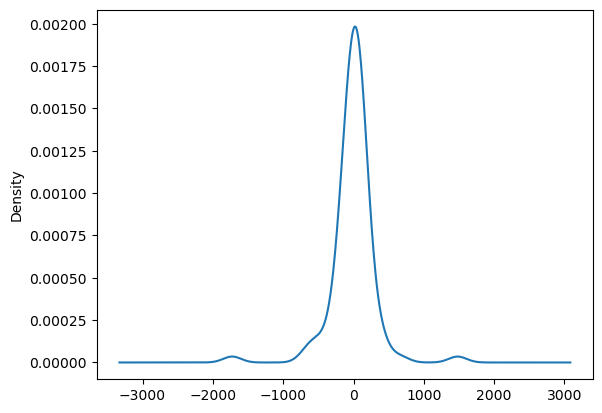

In [47]:
model.resid.plot(kind="kde")

In [48]:
test_data['Preds']=pred

<Axes: >

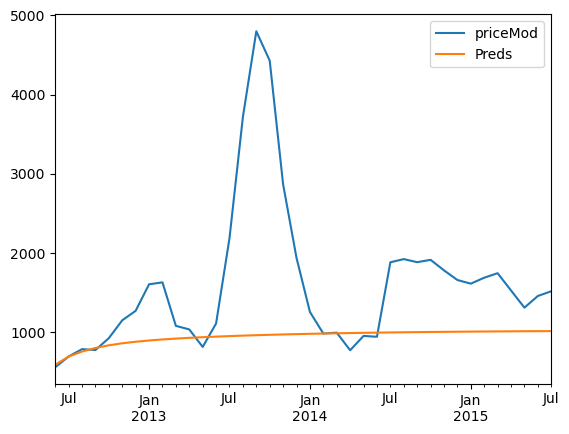

In [49]:
test_data[['priceMod',"Preds"]].plot()

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [51]:
sarimax=SARIMAX(train_data,order=(p,0,q),seasonal_order=(0,1,0,12))

In [52]:
model2=sarimax.fit()

In [53]:
pred2=model2.predict(start=pred_start_date,end=pred_end_date)

In [54]:
test_data['Preds2']=pred2

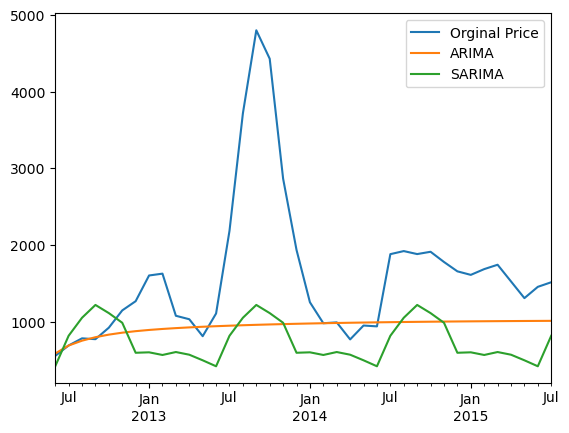

In [56]:
test_data[['priceMod',"Preds",'Preds2']].plot()
plt.legend(["Orginal Price","ARIMA","SARIMA"])

<Axes: >

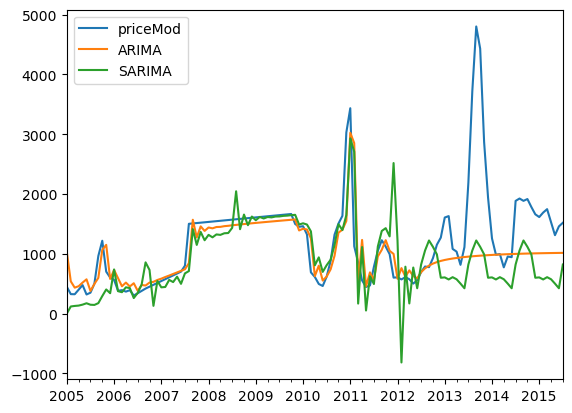

In [57]:
complete_obs=pd.DataFrame(stock_df)
complete_obs['ARIMA']=model.predict(complete_obs.index.min(),complete_obs.index.max(),)
complete_obs['SARIMA']=model2.predict(complete_obs.index.min(),complete_obs.index.max(),)
complete_obs.plot()

In [58]:
from sklearn.metrics import mean_squared_error
rmse_arima=np.sqrt(mean_squared_error(complete_obs['priceMod'],complete_obs['ARIMA']))
rmse_sarima=np.sqrt(mean_squared_error(complete_obs['priceMod'],complete_obs['SARIMA']))
print("RMSE ARIMA : ",rmse_arima," , RMSE SARIMA : ",rmse_sarima)

RMSE ARIMA :  669.9357265060644  , RMSE SARIMA :  753.6274282052125


## We have tried ARIMA and SARIMA
* SARIMA is a little bit better because it is able to capture the seasonality patterns in the data well
* The orginal data has some huge variations that are just temperal patterns
* One good thing here is that the SARIMA model is not overfitting and Generalise well to unseen data

## Auto ARIMA
##### WHY
        * No need to find values for p,q,d these will be learned during training
        * Significantly import the time required for modelling time series data

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1395.384, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1288.374, Time=0.21 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1321.909, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1514.889, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1285.631, Time=0.24 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1285.824, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1284.191, Time=0.58 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1283.138, Time=0.46 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1284.174, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1300.554, Time=0.26 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1286.130, Time=0.40 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1290.583, Time=0.15 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 3.521 seconds


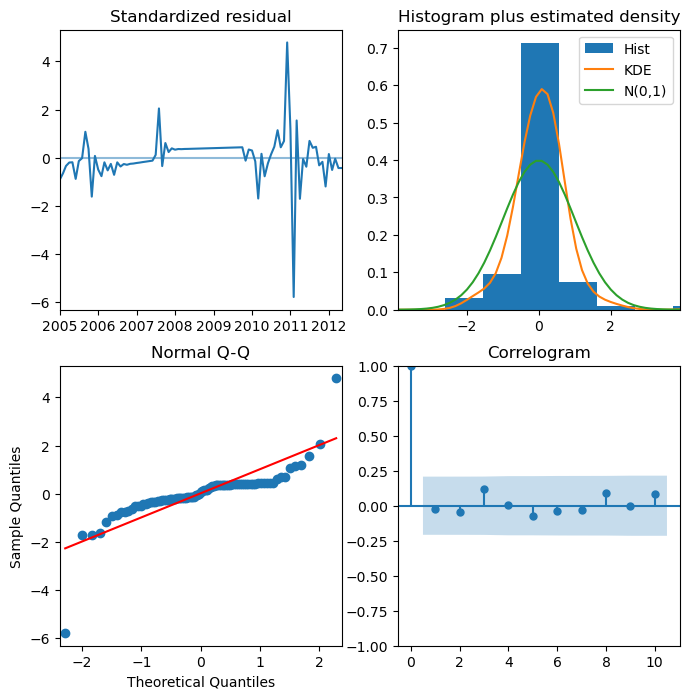

In [117]:
#!pip install pyramid-arima
#from pyramid.arima import auto_arima
#Faced problem in installing the above library so we are installed below library which is pmdarima
#!pip install pmdarima
import pmdarima as pm
auto_model=pm.auto_arima(train_data,start_p=0,start_q=0,test="adf",
                         max_p=15,max_q=15,n=1,d=0,max_d=3,seasonal=False,
                        start_P=0,start_Q=0,D=0,max_D=3,trace=True,error_action="ignore",
                        suprpess_warnings=True,stepwise=True,with_intercept=True,m=12,stationary=True)
auto_model.summary()
auto_model.plot_diagnostics(figsize=(8,8))
plt.show()

In [109]:
auto_preds=auto_model.predict(start=pred_start_date,end=pred_end_date,n_periods=len(test_data))

In [110]:
test_data['Preds_Auto']=auto_preds

<Axes: >

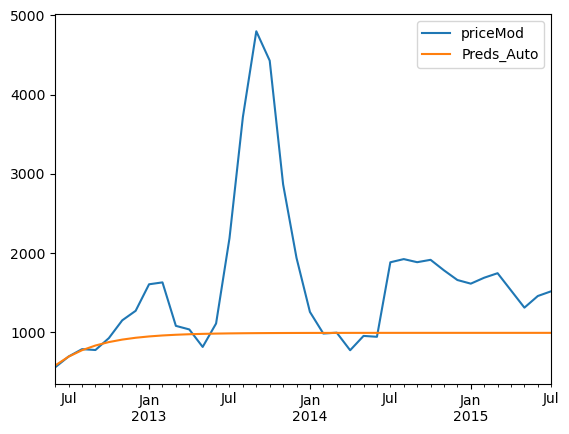

In [111]:
test_data[['priceMod','Preds_Auto']].plot()

In [112]:
complete_obs['Auto_Arima']=auto_model.predict(start=complete_obs.index.min(),end=complete_obs.index.max(),n_periods=len(complete_obs))

<Axes: >

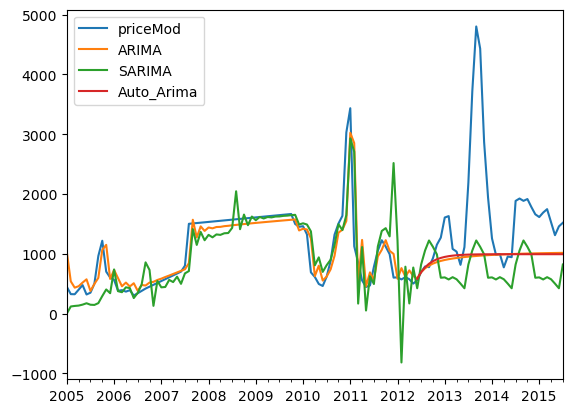

In [113]:
complete_obs.plot()

#### Conclusion
* We tried Auto Arima and we arent able to get as good of a generalization as SARIMA
* Next we have multiple markets are for building SARIMA models for each of these Markets is a hectic job
* One soution was auto arima but its not performing good here next maybe to take this as a regression task and buidl ml model
* For predicting 3 time dependent variable all at once we ca use Vector Auto Regressor(VAR) for multivariate time series
* Next option will be to build a SARIMAX with exogenus variables and adding market but it a appropriate method and better to build seperate models for the different markets 
* Next Option is to further Explore all the other methods and find a suitable one for our use case

### Building Auto SARIMAX Model with external variable

In [138]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
working_df=cleaned_df
encodering_col='market'
working_df['market']=encoder.fit_transform(working_df['market'])
working_df=working_df[['market','priceMod']]

In [135]:
working_df.iloc[9948:]

,market,priceMod
2006-07-01,98,201.0
2006-08-01,98,267.0
2006-09-01,98,270.0
2006-10-01,98,309.0
2006-11-01,98,295.0
...,...,...
2015-10-01,119,2886.0
2015-11-01,119,1996.0
2015-12-01,119,1126.0
2016-01-01,119,1034.0


In [140]:
SARIMAX_model = pm.auto_arima(working_df[['priceMod']], exogenous=working_df[['market']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=85.47 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=205951.284, Time=4.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=184651.501, Time=86.42 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=83.53 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=205949.313, Time=5.32 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=190328.040, Time=10.04 sec


MemoryError: Unable to allocate 130. MiB for an array with shape (37, 37, 12435) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 982, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 130. MiB for an array with shape (37, 37, 12435) and data type float64


AttributeError: Memoryview is not initialized